In [1]:
!wget https://raw.githubusercontent.com/adityatripathiiit/temporary/main/ratings.csv
import numpy as np
import csv
from numpy.linalg import svd
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

--2021-04-21 17:08:58--  https://raw.githubusercontent.com/adityatripathiiit/temporary/main/ratings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2483723 (2.4M) [text/plain]
Saving to: ‘ratings.csv’

ratings.csv         100%[===================>]   2.37M  --.-KB/s    in 0.04s   

2021-04-21 17:08:59 (60.7 MB/s) - ‘ratings.csv’ saved [2483723/2483723]



**Preparing the Data**

In [2]:
rating_matrix = []
max_user_id = 0
curr = 0
movie_index = {}
avg_rating_user = {}
avg_rating_movie = {}
user_count  = {}
movie_count = {}
with open('ratings.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        if(int(row[0]) not in user_count):
            user_count[int(row[0])] = 1
            avg_rating_user[int(row[0])] = float(row[2])
        else:
            user_count[int(row[0])] += 1
            avg_rating_user[int(row[0])] += float(row[2])

        max_user_id = max(max_user_id,int(row[0]))
        if(row[1] not in movie_index):
            movie_index[row[1]] = curr 
            curr += 1
            avg_rating_movie[int(row[1])] = float(row[2])
            movie_count[int(row[1])] = 1
        else:
            avg_rating_movie[int(row[1])] += float(row[2])
            movie_count[int(row[1])] += 1

        rating_matrix.append(row[:-1]) 

for id in user_count:
    avg_rating_user[id] = avg_rating_user[id]/user_count[id]

for id in movie_count:
    avg_rating_movie[id] /= movie_count[id]

**Creating indexed matrix and dividing the data into test and training sets**

In [3]:
user_movie_rating =  [[2.5]*(curr) for i in range(max_user_id+1)]

random.shuffle(rating_matrix)
split_index = len(rating_matrix)//5
test_data = rating_matrix[:split_index]
training_data = rating_matrix[split_index: ]

for row in training_data:
    user_movie_rating[int(row[0])][movie_index[row[1]]] = float(row[2])


**SVD Lowrank Approximation**

In [4]:
u, s, vt = np.linalg.svd(user_movie_rating, full_matrices=False)

def rank_k_approximation(k):  
    U_k = u[: , :k]
    s_k = s[:k]
    S_k = np.diag(s_k)
    Vt_k = vt[:k]
    rank_k_matrix = np.dot(U_k, np.dot(S_k, Vt_k))
    return rank_k_matrix

K = 100 
err_matrix = []
for i in range(1,100):
    err = 0
    rank_k_matrix = rank_k_approximation(i)
    for row in test_data:
        err +=(rank_k_matrix[int(row[0])][movie_index[row[1]]] - float(row[2]))**2 
    err_matrix.append(err)

**Baseline Algorithm**

In [5]:
def baseline(X, alpha, beta):
    x,y = X
    return alpha*x + beta*y

x = []
y = []
z = []
for user_id, movie_id, rating in training_data:
    x.append(avg_rating_user[int(user_id)])
    y.append(avg_rating_movie[int(movie_id)])
    z.append(float(rating)) 

alpha, beta = curve_fit(baseline, (x,y), z)[0]
print("Alpha: {} , Beta: {}".format(alpha,beta))
error_fit = 0

for user_id, movie_id, rating in test_data:
    error_fit += (float(rating)-alpha *avg_rating_user[int(user_id)] - beta* avg_rating_movie[int(movie_id)] )**2

print("Fitting error: {}".format(error_fit) )

Alpha: 0.37563004525945043 , Beta: 0.6321644470276497
Fitting error: 14140.822193949642


**Plots**

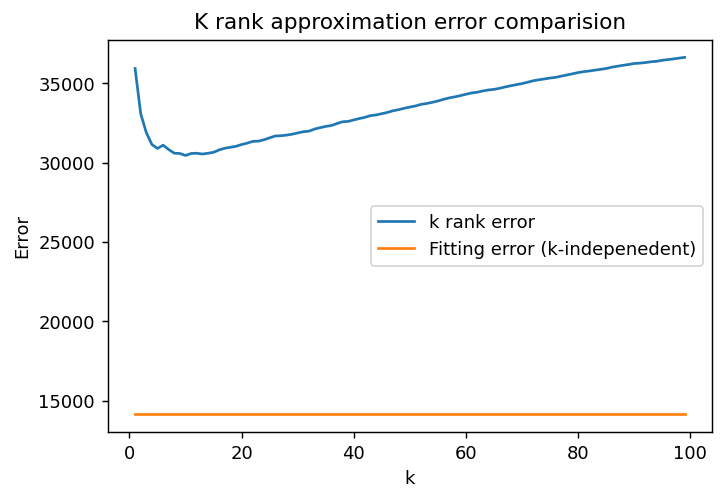

In [6]:
k = [i for i in range(1,100)]
plt.figure(dpi = 130)
plt.plot(k, err_matrix)
plt.plot(k, [error_fit for i in range(len(err_matrix))])
plt.legend(["k rank error", "Fitting error (k-indepenedent)"])
plt.title("K rank approximation error comparision")
plt.xlabel("k")
plt.ylabel('Error')
plt.show()

It can be seen from the plot above that for rank k approximation the error first decreases, but after a certain miniumn value it again starts rising. 
We can also see that the error of the baseline algorithm is much less compared to low rank approximation method. The baseline fitting error is independent of k as evident from the equation